In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
## 4.1 Loading and Cleaning the Data for Comparative Modeling

df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

# to make all columns camel case and labeled the same way
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

# EDA indicated 3 columns were irrelevant:

df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# EDA indicated fraudulent transactions only occur in CASH_OUT and TRANSFER types

df = df[(df['type'] == 'CASH_OUT' ) | (df['type'] == 'TRANSFER')]

#engineered columns 
df['sourceBalanceDiff'] = df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']
df['tarBalanceDiff'] = df['oldBalanceDest'] + df['amount'] - df['newBalanceDest']

df = pd.get_dummies(columns = ['type'], drop_first = True, data = df)

X = df.drop(columns = ['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    stratify = y)
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

over = SMOTE(sampling_strategy = 0.1)
X1_train, y1_train = over.fit_resample(X_train, y_train)

under = RandomUnderSampler(sampling_strategy = 0.5)
X2_train, y2_train = under.fit_resample(X_train, y_train)

steps = [('o', over), ('u', under)]
balance_pipe = Pipeline(steps = steps)
X3_train, y3_train = balance_pipe.fit_resample(X_train, y_train)

In [3]:
datasets = {
    "Unaltered" : [X_train, y_train],
    "Oversampled Minority" : [X1_train, y1_train],
    "Undersampled Majority" : [X2_train, y2_train],
    "Balanced SMOTE" : [X3_train, y3_train]
}

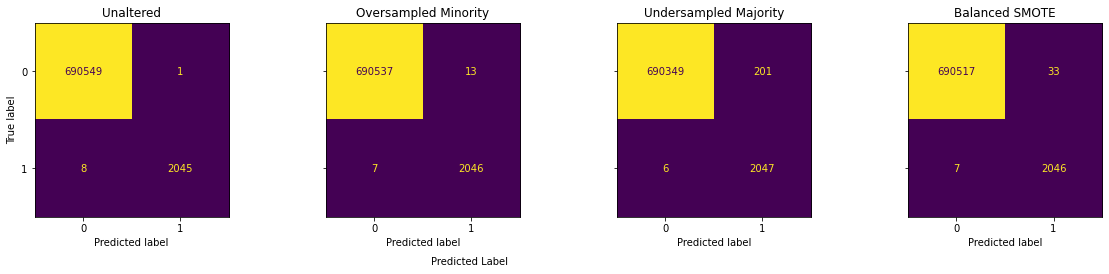

<Figure size 432x288 with 0 Axes>

In [17]:
f, axes = plt.subplots(1, 4, figsize = (20, 5), sharey = 'row')

models = []

for i, (key, dataset) in enumerate(datasets.items()):
    model = RandomForestClassifier()
    model.fit(dataset[0], dataset[1])
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax = axes[i])
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    if i != 0:
        disp.ax_.set_ylabel('')
    
    model_dict = {key: model, 'preds': y_pred, 'Confusion Matrix': cf_matrix}
    models.append(model_dict)
        
f.text(0.4, 0.1, 'Predicted Label', ha = 'left')
plt.show()
plt.savefig('./imgs/RFCbalancingComparison.jpg')

All right.  As predicted in the comparative modeling notebook, it looks like the unaltered dataset is going to be the best pairing for the Random Forest Classifier.  Let's try tuning this with a gridsearch.

In [5]:
sc_rfc = RandomForestClassifier()

sc_rfc.fit(Z_train, y_train)

RandomForestClassifier()

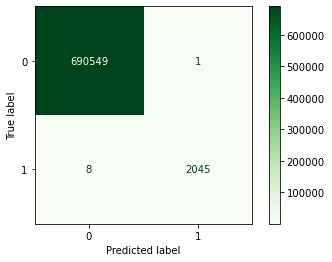

In [6]:
plot_confusion_matrix(sc_rfc, Z_test, y_test, cmap = 'Greens')
plt.savefig('./imgs/')

In [7]:
from sklearn.pipeline import Pipeline

In [8]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

In [9]:
pipe_params = {
    'ss__with_mean' : [True, False],
    'rfc__n_estimators' : [50, 100],
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__max_features': ['auto', 'log2', None]
}

In [10]:
grid = GridSearchCV(pipe, 
                    pipe_params,
                    cv = 3,
                    verbose = 1,
                    n_jobs = -2)

In [11]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_features': ['auto', 'log2', None],
                         'rfc__n_estimators': [50, 100],
                         'ss__with_mean': [True, False]},
             verbose=1)

In [12]:
grid.score

<bound method BaseSearchCV.score of GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_features': ['auto', 'log2', None],
                         'rfc__n_estimators': [50, 100],
                         'ss__with_mean': [True, False]},
             verbose=1)>

In [13]:
grid.best_score_

0.9999870055240961

In [14]:
grid.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(criterion='entropy', n_estimators=50))])

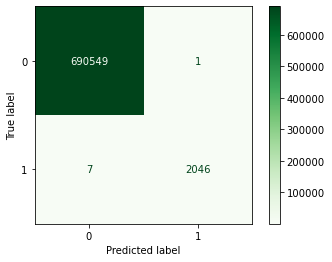

In [16]:
plot_confusion_matrix(grid, X_test, y_test, cmap = 'Greens')
plt.savefig('./imgs/finalConfusionMatrix.jpg')